## HOWTO estimate parameter-errors using Monte Carlo - an example with python

Will Clarkson, Sat March 8th 2014

UPDATED Sun March 14th 2021 with more recent system version and a few other minor style updates (now runs on python 3 and should be backwards-compatible to python 2.7). 

I have started the process of updating this series of HOWTOs to run on more recent systems than what I had access to in 2014 (and also with improvements to the code, e.g. "N" --> "np" for numpy). I make no promises that this will be regularly updated. The new versions will be curated at this public github repository (MIT license): https://github.com/willclarkson/astroStatsHOWTOsDearborn

*(Note: This is the first really in-depth HOWTO I've put up at Dearborn, and it contains a number of other useful points about data analysis with python (e.g. how to fit a curve to data, how to annotate plots...). Even if you know Monte Carlo backwards and forwards, you may find the syntax examples below useful. As with all python "Notebooks," you should be able to reproduce everything here just by pasting the commands into your IPython interpreter.*)

A few summary points (since this HOWTO has become fairly long:

[1]. Monte Carlo is quick (to code), flexible, and easy to do - the working code examples below are only a few lines long.

[2]. It produces empirical error estimates on your fitted parameters, no matter how complicated the relationships of the parameters to the data;

[3]. The estimated range of parameters depends on the details of the simulation, so make sure it's as realistic as you can make it;

[4]. There are some interesting subtleties in how you report the error estimates; the best way to report them is to show not only a one- or two-sided range, or (better) the full covariance matrix, but (best) to provide the complete distribution of parameter-estimates over your simulations.

[5]. You can use Monte Carlo to realistically investigate how to improve your experiment to allow parameter-uncertainties sufficiently small to be scientifically useful.

### Introduction

One of the most important pieces of model-fitting is to determine the "uncertainty" in the value of some parameter in the model. You might have fit some value of your model parameter to data, and it may even go through most of the datapoints and be consistent with your prior expectation on the parameter-values. But unless you know what range of values of this parameter are consistent with the data, you really don't know if your model fits at all. 

So, how do we know what range of values of a parameter are consistent with the data?

### Background

In the material below I'm skirting round some very deep and interesting ideas in order to show a practical way to determine this range. However a few points are in order to clarify what I'm talking about here. 

In what follows, I'll denote the "error on the parameter" to mean "the spread in the parameter values that are consistent with the data." This is a somewhat vague definition (see any standard text for more detail). In the context of empirical estimators on the parameter-spread, one might report the "68 percent confidence interval" to mean "the range of fitted values we would obtain 68% of the time" when the true value is at or near our best-fit value. Since we can always draw likelihood contours centered on any point in the distribution, we can tighten this up a bit by requiring the range to be "centered" on the most likely value, in the sense that the trials are ordered in increasing order of likelihood and the middle set returned as the range. This is also formally a bit vague, but good enough for our purposes here. It's how we know what we'd get "X% of the time" that is the important part. 

It's common in the literature to condense (massively) the information contained in the deviations from the "best-fit" value to report the "1-sigma" range, often reported as $a \pm s$ where $s$ is the "1-sigma" range. In most cases this means the range of values that bound 68 percent of the measured values under a large number of experiments (or simulations). Formally, this practice throws away most of the information the reader might want to know: even under gaussian measurement errors the posterior distribution of the best-fit parameter can be highly asymmetric and non-gaussian. Simply reporting one number throws away the true distribution and is not good practice. It's also (less) common to report a two-sided error, like: $a^{+s}_{-r}$, where $s$ is a measure of the standard deviation of the part of the distribution above the best-fit, and $r$ below it (there is a factor-two to think about here; if the distribution were symmetric, you'd want $x^{+s}_{-s}$ to denote $x\pm s$ not $x \pm 2s$...). This usually implicitly approximates the upper part to half a gaussian and the lower part to a gaussian with a different standard deviation. This still may not be a good approximation to the true distribution of best-fit parameters. However in many cases this may be sufficient (say, when you are reporting positions and their errors for ten thousand stars in a catalog and don't want to plot the full posterior for each one - although even here you can provide the graphs electronically.)

I will also use a rather classical definition of what I mean by "consistent with data" and "best-fit." When finding the model-parameters that best fit the data, we can maximize the probability of getting the measured data values given the model and our choice of best-fit parameter values. If the parameter-values are a good fit, then the deviation between observed data and model predictions is small; if they are a bad-fit, then this deviation is large. This "maximum-likelihood" way of thinking is from some points of view backwards - we are maximizing the probability that the model match the data (the "Bayesian" approach) by maximizing the probability that the data match the model. In many practical cases the two approaches give similar values and ranges, and the one approach can be tweaked to approach the other. (For more, see any standard text on data analysis.)

We make the assumptions that:

[1] our model f(x) really does describe the behavior we are measuring:

[2] any deviations between the perfect underlying pattern predicted by f(x) and those we measure y(x), are due only to measurement error that we can parameterise. (This assumption can be relaxed, but in this HOWTO I preserve it to keep things simple). A common choice of this parameterization is a Gaussian - under this parameterization then curve-fitting by minimising the chi-square statistic is formally identical to maximizing the likelihood of (data given model).

If we were to conduct a large (~infinite?) number of identical experiments, then, the "true" parameters of our model f(x) would not change, but those are inaccessible to us - the parameters that best describe the data would change a little between experiments because we don't measure exactly the underlying behaviour. **The range of best-fit values returned across the set of experiments is then a reasonable estimate for the range in the parameter-values allowed by the data.**

### Error-estimates from Monte Carlo

Since we cannot do an infinite number of repeat-experiments (sometimes we cannot even do one if the behaviour we measure is transient), we need another way to predict what range of parameter values would be returned if we could do them. 

One way is the formal error-estimate: - *IF* the measurement errors all follow the same distribution, and if they are "small enough," then you can use standard error-propagation to take the measurement error and propagate it through to get a formal prediction on the error of the parameter. *BUT* there's no guarantee that this will work in all cases, for at least three obvious reasons. 

(i) You can think of simple models in which the Taylor series approximation behind standard error-propagation may become pathological (to think about: what is the formal variance of the Lorentz distribution, for example? How well might error-propagation work for, say, 1/x near x=0?). Or, 

(ii) your real-life science example may include a model whose error propagation is quite nasty formally. Or, 

(iii) for various real-world reasons you might be using a model-fitting scenario that breaks the chain of error-propagation in some way (might be e.g. numerical approximations in there if you're near a singularity in the model, or you might have something apparently innocuous like $|x|$ in the model).

What you need in the real world, is a method that will empirically find the range of parameters that fit the model to some level of "confidence" without actually doing ten thousand re-runs of the experiment to determine this range.



This is what Monte Carlo does in this context$^1$: ** *simulate a large number of fake datasets and find the best-fit parameters using exactly the same method that you're using to fit your real data.* ** The range of returned parameters under these fake experiments is then a reasonable approximation to the true underlying error in the best-fit parameters.

Even here there are important subtleties. The uncertainty in the best-fit parameter (i.e., the range of parameters consistent with the data) can depend strongly on the truth-value of the parameter - which is unknown. The formally correct procedure in these cases is to find the distribution of returned values under a range of truth-values, and use an ordering principle in the likelihood to find the range of recovered values when the truth-value is allowed to vary. The famous (to Physicists!) paper by Feldman & Cousins illustrates how to properly do this (link below). 

Feldman & Cousins 1997: A Unified Approach to the Classical Statistical Analysis of Small Signals
http://arxiv.org/abs/physics/9711021

In many cases, however, you can assume the range of consistent-values does not change much with the truth-value (or verify that this is so through simulation), and simulate your fake experiments using the same truth-value for each trial. The range of best-fit values when this truth-model is "experimentally" sampled is then a reasonable estimate for the uncertainty on the parameter-value. This is what we do in this HOWTO.

$^1$(I say "in this context" to distinguish error-estimates by Monte Carlo from Monte Carlo integration).

### Contexts in which you might see Monte Carlo error-estimates

Before (finally) moving on to the example with code, it's worth listing a few of the contexts in which you might see this. Any decent modern textbook will have lots more (e.g. Wall & Jenkins, Practical Statistics for Astronomers has a good view from 40,000 feet). Typical cases:

[1]: Well-understood model, error distribution understood, want parameter errors (the case in this HOWTO); 

[2]: Well-understood model, error distribution understood, want to know what signal-strength you might mistakenly ascribe to data that doesn't actually contain a signal ("detection limits");

[3]: Well-understood model, error distribution not well-behaved or well-understood (in this case use bootstrap resampling; more about this in a future HOWTO);

[4]: Well-understood model, error distribution understood, we have information from some other measurements that constrain one or more of the relevant parameters (i.e. Bayesian framework: Markov Chain Monte Carlo is a good choice here);

[5]: Well-understood model, error distribution not understood, high-dimensional parameter space (Markov Chain Monte Carlo again)

As I hope to show in a future HOWTO, Markov Chain Monte Carlo in some sense is a superset of the techniques I describe here, as it allows these methods to be extended to prior information.

If the model is NOT well-understood, or there are a few good choices for the models that parameterise the observed variation, then we are in the range of model-comparison, or alternatively non-parametric comparisons. Those are also outside the scope of this HOWTO.

## A practical example: 1/t decay with only six measurements

With that material aside, here's a practical example. First we generate a "measured" dataset that has been perturbed from the "truth" parameters (this corresponds to our experiment). Then we fit this dataset to estimate the value of the power-law index by which y(x) decays over time. Then we use Monte-Carlo to estimate the uncertainty in this best-fit value.

First we import a few modules we'll need. NOTE: if you enter the lines below into your python command-line (all but [8]) in order, you should be able to reproduce all the steps I'm doing here. 

In [133]:
import pylab as P
import numpy as np
from scipy import optimize


(The following line is needed in the ipython notebook: you wouldn't need to type this from the python prompt)

In [134]:
%matplotlib inline

### "Experimental" data

First we do the experiment - here we simulate the data from 1/t decay. I use uniform error for simplicity of exposition, but there's no reason we could not make things more realistic later on. Let's suppose we have a small-ish number of datapoints:

In [135]:
xMeas = np.random.uniform(0.5,3.0,size=6)
yTrue = 1.5/xMeas
sError = 0.1
yMeas = yTrue + np.random.normal(scale=sError, size=np.size(yTrue))


Let's plot this to see how our experiment looked:

(0.4, 3.0)

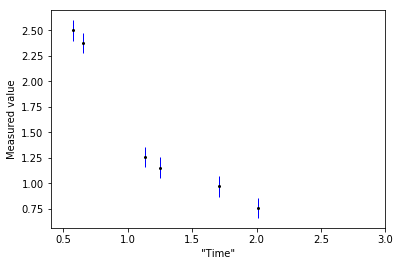

In [136]:
P.errorbar(xMeas,yMeas,yerr=sError,lw=0,elinewidth=1,ecolor='b', fmt='ko',markersize=2)
P.xlabel('"Time"')
P.ylabel('Measured value')
P.xlim(0.4,3.0)

### Fitting our experimental data

Now we fit this data with our model. For this example, I'll assume that for whatever reason we've decided to use scipy's "curve_fit", which is pretty robust (although does not include measurement error in its fitting). No matter - the Monte Carlo will tell us what range of parameters come out under our chosen fitter.

First we define the function to fit to this data. We want to have enough free parameters to actually capture the behavior we think is going on, but not introduce redundant parameters. We also want to furnish the fitter with an initial guess, which I'll call "vGuess" below:

In [137]:
def f_decay(x,a,b):
    return a*x**(b)


We need to supply the fitter with an initial guess of the parameters. Since we'll be using the same guess for our Monte Carlo below, I'll define this as a separate element here. I'll also make the initial guess obviously "wrong" - i.e. assuming a quadratic when the underlying behavior is 1/t - to see what happens.

In [138]:
vGuess = [2.0,-2.0]

Now we run the fitter. Like many of scipy's optimization routines, the fitter needs to know (i) what function to use, (ii) the data to fit, and finally (iii) an initial guess of the parameteres. curve_fit happens to return the best-fit parameters as the first of two return-values. So we need to send those two returned values into two new variables - "vPars" will hold the returned parameters-fit.

In [139]:
vPars, aCova = optimize.curve_fit(f_decay, xMeas, yMeas, vGuess)

Let's take a look at those best-fit parameters:

In [140]:
print(vPars)


[ 1.49525025 -0.9674022 ]


That's not too bad - the "Truth" values were y(x) = 1.5/x and we have found y(x) = 1.46/x^(1.13). Let's take a look at what this model looks like over the data:

Text(0.5, 1.0, 'Fitted curve (green) and "truth" curve (red dashed)')

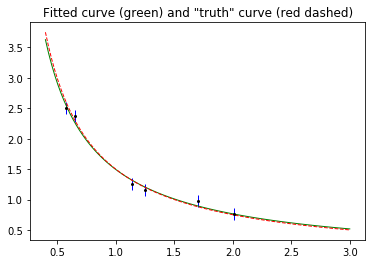

In [141]:
xFine = np.linspace(0.4,3.0,100)
P.errorbar(xMeas,yMeas,yerr=sError,lw=0,elinewidth=1,ecolor='b', fmt='ko',markersize=2)
P.plot(xFine, f_decay(xFine,*vPars), 'g-', lw=1) # Fitted parameters
P.plot(xFine, f_decay(xFine,1.5,-1.0), 'r--', lw=1) # Parameters used to generate data
P.title('Fitted curve (green) and "truth" curve (red dashed)')

Visually, this isn't **too** horrendous. At this point we might be tempted to claim that "obviously" our data shows y(x) = constant/$x^{0.97}$ since that model goes through the points.

But what range of parameter-values are consistent with a dataset like this?

### Monte Carlo - allowing observing times to vary

What we do next depends on what level we think our hypothetical experiments might differ from each other. I'll make the assumption here that the times of measurement between x=0.5 and x=3.0 were random. In that case, we would need to include this variation of measurement-time in our simulations in order to report the range of values another experimenter might find if they used a similar setup. So, we will generate a large number of datasets, re-fit the parameter values where the measurement-times are also not under our experimenter's control, and then find the range of parameters that match the data. 

We need to set up a few things first: The number of trials and the combined set of best-fit parameters, for all the model parameters (initially empty). So:

In [142]:
nTrials = 4000
aFitPars = np.array([])

Now we actually do the simulations. Each time we need to generate the data as well as fit it. 

(There is one syntax complication: we cannot stack a 1d vector onto an empty array in python, so there is an if/then for the FitPars array: if it's empty, copy the latest round of fitted parameters into it, if not then stack the latest round of fitted parameters onto what we have so far.)

In [143]:
for iTrial in range(nTrials):
    xTrial = np.random.uniform(0.5,3.0,size=np.size(xMeas))
    yGen = 1.5/xTrial
    yTrial = yGen + np.random.normal(scale=sError,size=np.size(yGen))
    
    # We use a try/except clause to catch pathologies
    try:
        vTrial, aCova = optimize.curve_fit(f_decay,xTrial,yTrial,vGuess)
    except:
        dumdum=1
        continue  # This moves us to the next loop without stacking.
    
    #here follows the syntax for stacking the trial onto the running sample:
    if np.size(aFitPars) < 1:
        aFitPars=np.copy(vTrial)
    else:
        aFitPars = np.vstack(( aFitPars, vTrial ))
        

A couple points to note in the above chunk: 

(i) All those np.size() calls are to ensure that the various arrays are consistent with the size of the measured data. We could equally well have typed "6" in most of those places, but then we'd have to change it each time a new experiment was done with different numbers of datapoints. Also, 

(ii) Your fitting routine might sometimes not work. A more sophisticated analysis would catch these errors: here I'm just using python's "try/except" clause to gracefully ignore the bad cases. (If you're finding that more than a percent or so of cases are breaking, you may want to double-check whether your model has too few or too many parameters for the data). Finally:

(iii) In this example, I am starting with an empty aFitPars array and then stacking on the fit-values only if the fitting routine ran without failing. The "continue" statement stops the routine from dumbly stacking on the last fit-value if the fit failed. I do things this way so that the fitpars array is always the correct size to match the number of correctly-run trials.

Having done all that, let's look at the size of the set of trials:

In [144]:
np.shape(aFitPars)

(4000, 2)

This shows that all our 4000 trials were successful, which isn't too bad. Now, let's look at the distribution of powers of x that came out of the fit:

In [145]:
print(np.median(aFitPars[:,1]))
print(np.std(aFitPars[:,1]))

-0.9981492043446679
0.13778476093391592


Let's take a graphical look at this parameter. We'll use matplotlib's "hist" feature to generate and plot the distribution for convenience, but there are other better tools you'll likely come across.

0.13778476093391592


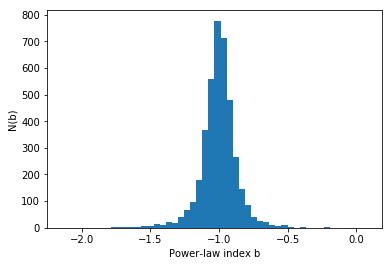

In [146]:
P.hist(aFitPars[:,1],bins=50)
P.xlabel('Power-law index b')
P.ylabel('N(b)')

print(np.std(aFitPars[:,1]))


We see that the standard deviation of our fitted parameter is pretty high - our measurement of (constant/$x^{1.13}$) is more accurately (constant/$x^{0.97 ~ \pm ~0.138}$). This is consistent with 1/x within the range of values we have recovered.

Notice also that our 1D distribution looks nice and gaussian. But is the situation really this simple? Let's look at both power-law components together:

Text(0, 0.5, 'Power-law index b')

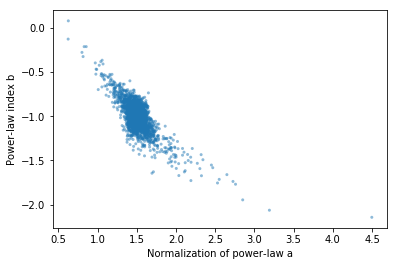

In [147]:
P.scatter(aFitPars[:,0], aFitPars[:,1], alpha=0.5, s=9, edgecolor='none')
P.xlabel('Normalization of power-law a')
P.ylabel('Power-law index b')

Here follows a little bit of matplotlib syntax to show this in a slightly more visually appealing way:

Text(0, 0.5, 'Power-law index b')

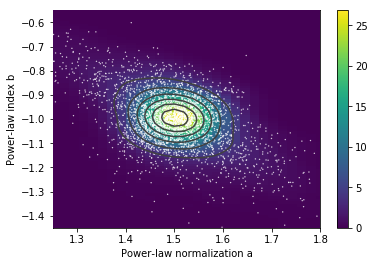

In [148]:
from scipy.stats import kde
x,y=aFitPars.T

# Use a kernel density estimator to produce local-counts in this space, and grid them to plot.
k = kde.gaussian_kde(aFitPars.T)
nbins=200
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# Show the density
P.pcolormesh(xi, yi, zi.reshape(xi.shape), zorder=3)
P.colorbar()

# Show the datapoints on top of this, and also the contours. "zorder" sets the vertical order in the plot.
P.scatter(aFitPars[:,0], aFitPars[:,1], c='w', s=2, zorder=15, edgecolor='none',alpha=0.75)
P.contour(xi,yi,zi.reshape(xi.shape), zorder=25, colors='0.25')


P.ylim(-1.45,-0.55)
P.xlim(1.25,1.80)
P.xlabel('Power-law normalization a')
P.ylabel('Power-law index b')


Even in our simple two-parameter problem the results are quite interesting. For example, the correlation between parameters appears to switch sign the farther from the center of the cloud we go - perhaps indicating different regimes depending on the clustering of measurement-times.



### Were our observing times special?

Now suppose instead that we had good reason to make measurements at the times (x-values) that we did. Perhaps a realistic estimate for the errors should not allow the measurement times to vary.

Let's try another Monte-Carlo, this time asking what parameter values we recover if we make identical experiments at the same times as our real data, but still subject to experimental error at those times:

In [149]:
aFitSameTimes=np.array([])
for iTrial in range(nTrials):
    yGen = 1.5/xMeas  # Same measured times this time!
    yTrial = yGen + np.random.normal(scale=sError,size=np.size(yGen))
    
    # We use a try/except clause to catch pathologies
    try:
        vTrial, aCova = optimize.curve_fit(f_decay,xMeas,yTrial,vGuess)
    except:
        dumdum=1
        continue  # This moves us to the next loop without stacking.
        
    #here follows the syntax for stacking the trial onto the running sample:
    if np.size(aFitSameTimes) < 1:
        aFitSameTimes=np.copy(vTrial)
    else:
        aFitSameTimes = np.vstack(( aFitSameTimes, vTrial ))

In [150]:
np.shape(aFitSameTimes)

(4000, 2)

Let's look at the spread in recovered values as we did before:

Text(0.5, 1.0, 'Same measurement times each trial')

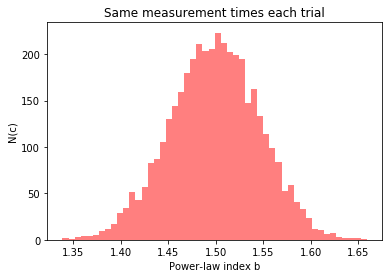

In [151]:
P.hist(aFitSameTimes[:,0],bins=50, alpha=0.5,color='r')
P.xlabel('Power-law index b')
P.ylabel('N(c)')
P.title('Same measurement times each trial')

In [152]:
print(np.median(aFitSameTimes[:,1]))
print(np.std(aFitSameTimes[:,1]))


-0.9988972317956054
0.06646615314299915


Let's look at those parameters plotted against each other as we did before.

Text(0.5, 1.0, 'Same measurement times each trial')

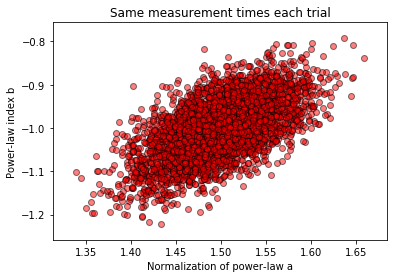

In [153]:
P.scatter(aFitSameTimes[:,0], aFitSameTimes[:,1],c='r', s=36, edgecolor='k', alpha=0.5)
P.xlabel('Normalization of power-law a')
P.ylabel('Power-law index b')
P.title('Same measurement times each trial')

# Set the same axis-ranges as above for visual comparison
#P.xlim(1.30, 1.70)
#P.ylim(-1.4,-0.6)

As we might expect, the measurements are still correlated, but the distribution is tighter. Let's take a look at the two sets of parameters on top of each other:

Text(0.5, 1.0, 'Random observing times (blue) and frozen times (red)')

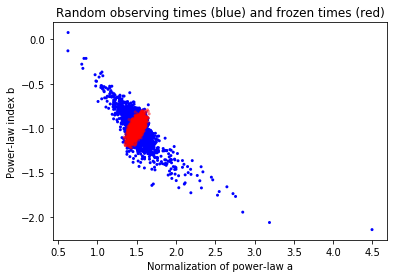

In [154]:
# the alpha values below are transparency values for plots.
P.scatter(aFitSameTimes[:,0], aFitSameTimes[:,1],c='r', s=9, edgecolor='none', zorder=25, alpha=0.5)
P.scatter(aFitPars[:,0], aFitPars[:,1],c='b', s=9, edgecolor='none', zorder=5)

P.xlabel('Normalization of power-law a')
P.ylabel('Power-law index b')
P.title('Random observing times (blue) and frozen times (red)')

Or we can generate our contours and compare the two sets visually:

Text(0, 0.5, 'Power-law index b')

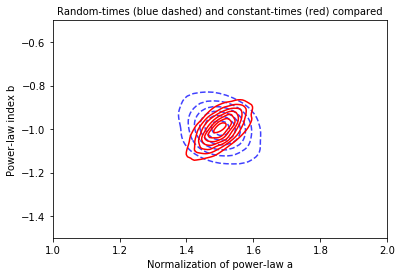

In [155]:
xS,yS=aFitSameTimes.T
kS = kde.gaussian_kde(aFitSameTimes.T)
nbins=50
xiS, yiS = np.mgrid[xS.min():xS.max():nbins*1j, yS.min():yS.max():nbins*1j]
ziS = kS(np.vstack([xiS.flatten(), yiS.flatten()]))

# Now let's plot this over the previous (xi,yi,zi) case:
P.contour(xi,yi,zi.reshape(xi.shape),colors='b',lw=2, zorder=5, alpha=0.75, linestyles='dashed', label='random times')
P.contour(xiS, yiS, ziS.reshape(xiS.shape), colors='r', zorder=15, alpha=1.0, label='times frozen')

P.xlim(1.0,2.0)
P.ylim(-1.5,-0.50)
P.title('Random-times (blue dashed) and constant-times (red) compared', fontsize=10)

P.xlabel('Normalization of power-law a')
P.ylabel('Power-law index b')

That these two sets are not terribly different (but not identical!) indicates that the particular experiment (xMeas, yMeas at the beginning) didn't happen to pick a hugely fortuitous set of observing "times" (i.e. x-values), although it looks like the values that were picked were generally a bit better than any random set of six observing times.

### Discussion

So, which value for the spread of the power-law index "b" should we use in our hypothetical publication?

That depends on which of the scenarios simulated you believe to be the most honest representation of the differences between predicted and actual data one would encounter in real life. What you CANNOT do is just pick the scenario that gives the smallest range just because you want to report the smaller error!

It's usually best to be as upfront as possible about what your errors mean. This is where in your paper you would report not just the range, but also under what circumstances this was estimated. If you assumed your measurement times were constant when making the monte carlo, then say so - and you should also justify in the paper why you made this assumption. In this simple case above, the differences between assuming any set of random times (blue) and the exact times (red) is not very large, but you still want the reader to understand as much as possible about your data.

In most cases - even the simple toy problem here - you should really go one better, and give the reader not just the range of values consistent with your data, but the full likelihood function of the fitted parameters. This is usually hard to parameterise but easy to show - just show the graph of the recovered parameters (any of the example graphs above would be good)!

Notice also that in the case of the toy problem here, even a two-parameter model with a very simple form has led to real covariance between the fitted parameters under our monte carlo experiments. Under this situation, what would the 1-sigma variation in one of the parameters mean? 


In a situation like this, you can easily report not just the standard deviation (or its square, the variance) but instead the *Covariance* of the parameters. The diagonal elements are the variance of each parameter, while the off-diagonals indicate the covariance between each pair of parameters. In python, this is easy:

In [156]:
aCovFit = np.cov(np.transpose(aFitSameTimes))

Looking at the resulting covariance matrix, we see that - like our graphs above suggest - the two parameters do indeed vary together:

In [157]:
print(aCovFit)


[[0.00220256 0.00190299]
 [0.00190299 0.00441885]]


In [158]:
print(np.std(aFitPars[:,0]))
print(np.sqrt(aCovFit[0,0]))


0.13556475825680783
0.04693146004038742


That difference between the diagonal element and the standard deviation of the fitted parameter "a" is small but significant! It means there is a nonzero covariance. We can get a little bit more insight by computing the normalized covariance (the correlation). We see that the off-diagonal terms are about 61 percent of the diagonal terms (expressed as variance not standard deviation). 

In [159]:
np.corrcoef(np.transpose(aFitSameTimes))


array([[1.        , 0.60998179],
       [0.60998179, 1.        ]])

If you're more familiar with the standard deviation rather than the variance, you might take the square root to get a visual handle on how large this correlation is, remembering to use the absolute value in case of negative off-diagonal terms (which we'd get in the case of variables anti-correlated with each other). I have not seen this done much, but you might find it more intuitive. Your mileage may vary.

In [160]:
np.sqrt(np.abs(np.corrcoef(np.transpose(aFitSameTimes))))

array([[1.        , 0.78101331],
       [0.78101331, 1.        ]])

The above has been a quick introduction into what monte carlo is, how it works, and how to do it in python. 

For more on the ways to report the ranges when two parameters vary against each other, take a look at any standard text on data analysis in the sciences. Bevington & Robson has a good discussion at about the right level, Numerical Recipes also has some interesting advice.

# A more interesting example: powerlaw plus constant background

Now we move on to a more "realistic" example: there is a power-law decay above some unknown constant background, which we include in our model. As we will see, this leads to significant deviations from the bivariate gaussian-like posterior distrbutions we saw above, because with only a few datapoints it is statistically difficult to determine which of the background, normalization should account for this offset level. 

(Note that we could flip this around and say that if we KNOW that the two-parameter model does fit our data, then throwing in a third parameter significantly complicates the range of consistent values.)

We begin as before, this time with the background term included, and assuming our experimenter has been able to take just a few more datapoints. We'll define our slightly more complex function and use the same function to generate the "experimental" data, the "truth" values and the monte-carlo simulations. 

In [161]:
def f_expt(x,a,b,c):
    return a*x**(b)+c

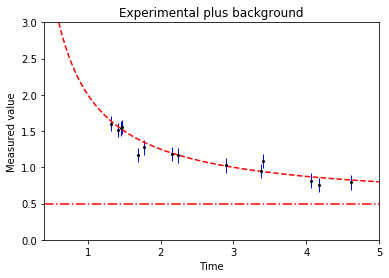

In [162]:
nData=14
sError=0.1
xMeas=np.random.uniform(0.5,5.0,size=nData)
yTrue=f_expt(xMeas,1.5,-1.0,0.5)
yMeas = yTrue + np.random.normal(scale=sError, size=np.size(yTrue))
P.errorbar(xMeas,yMeas,yerr=sError,lw=0,elinewidth=1,ecolor='b', fmt='ko',markersize=2)

# Some syntax to make the plot a bit clearer
P.xlim(0.4,5.0)
P.ylim(0.0,3.0)
P.title('Experimental plus background')
P.xlabel('Time')
P.ylabel('Measured value')

# Plot the total model and the constant background
xFine=np.linspace(0.4,5.0,100)
P.plot([np.min(xFine),np.max(xFine)], [0.5,0.5],'r-.')
P.plot(xFine,f_expt(xFine,1.5,-1.0,0.5), 'r--')


As before, we'll fit our new model to this data with background. We'll assume an optimistic guess with lower than true background:

In [163]:
vGuess=[2.0,-2.0,0.2]

In [164]:
vPars, aCova = optimize.curve_fit(f_expt, xMeas, yMeas, vGuess)

In [165]:
print(vPars)

[ 1.4563466  -0.9404785   0.46574376]


This time the parameters are quite a bit different than input: the "truth" values were [1.5, -1.0, 0.5]. 

But is this really so "bad?" How do we know? Let's view this graphically, plotting the fitted parameters (green) over the generated parameters (red dashed):

Text(0, 0.5, 'Measured value')

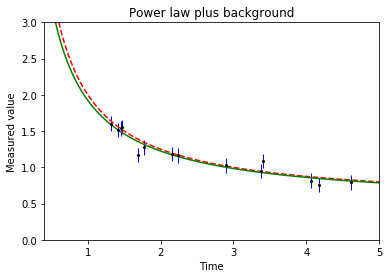

In [166]:
P.errorbar(xMeas,yMeas,yerr=sError,lw=0,elinewidth=1,ecolor='b', fmt='ko',markersize=2)
P.plot(xFine,f_expt(xFine,1.5,-1.0,0.5), 'r--')
P.plot(xFine,f_expt(xFine,*vPars), 'g-')

# Same labels as before:
P.xlim(0.4,5.0)
P.ylim(0.0,3.0)
P.title('Power law plus background')
P.xlabel('Time')
P.ylabel('Measured value')

We see that, even though the fitted parameters are different from the generated parameters by quite a bit more than in the two-parameter case, the two sets of best-fit parameters produce quite similar curves. This is an indication that our experimental setup might not be sufficient to distinguish the parameters of our model. 

Pressing on with this, what range of parameters are consistent with the data we do have? Let's use Monte Carlo to find out. Once again, we initialise our set of fit parameters:

In [167]:
nTrials = 4000
aFitExpt = np.array([])

In [168]:
for iTrial in range(nTrials):
    xTrial = np.random.uniform(0.5,5.0,size=np.size(xMeas))
    yGen = f_expt(xTrial,1.5,-1.0,0.5)
    yTrial = yGen + np.random.normal(scale=sError,size=np.size(yGen))
    
    # We use a try/except clause to catch pathologies
    try:
        vTrial, aCova = optimize.curve_fit(f_expt,xTrial,yTrial,vGuess)
    except:
        dumdum=1
        continue  # This moves us to the next loop without stacking.
    
    #here follows the syntax for stacking the trial onto the running sample:
    if np.size(aFitExpt) < 1:
        aFitExpt=np.copy(vTrial)
    else:
        aFitExpt = np.vstack(( aFitExpt, vTrial ))

Since our model is now more complex given the data, let's see what fraction of trials were successful:

In [169]:
np.shape(aFitExpt)

(3951, 3)

As we might have expected, a small fraction (about 1-2 percent) of the trials failed. The "try/except" clause above handled this gracefully. So - let's take a look at the distribution of parameters under these simulations:

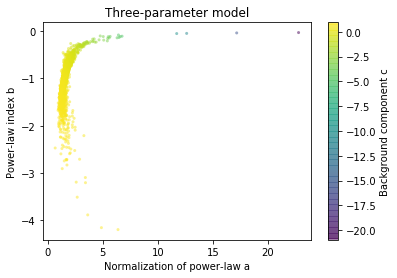

In [170]:
P.scatter(aFitExpt[:,0], aFitExpt[:,1], c=aFitExpt[:,2], alpha=0.5, s=9, edgecolor='none')
P.xlabel('Normalization of power-law a')
P.ylabel('Power-law index b')
P.title('Three-parameter model')
P.colorbar(label='Background component c')

We see that the distribution of fitted parameters is completely different from the two-parameter case above. Let's zoom in:

(-2, 0)

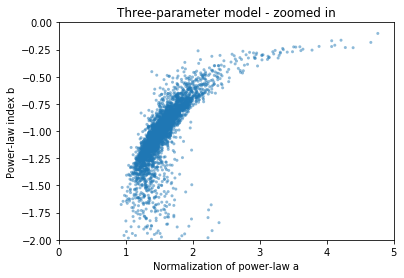

In [171]:
P.scatter(aFitExpt[:,0], aFitExpt[:,1], alpha=0.5, s=9, edgecolor='none')
P.xlabel('Normalization of power-law a')
P.ylabel('Power-law index b')
P.title('Three-parameter model - zoomed in')
P.xlim(0,5)
P.ylim(-2,0)

Let's see what range of parameters comes out of those simulations. Note a couple of things: 

(i) two of the histograms below have a log10 scale due to the very long tails of the distributions;

(ii) We have set limits on those histograms. This is a little dangerous in practice - we don't want to throw away samples when computing the range - but those limits were set after examining the full range (we also don't want to include the really pathological cases like the very bottom-right datapoint in the scatterplot two figures up). So:

Text(0, 0.5, 'N(a)')

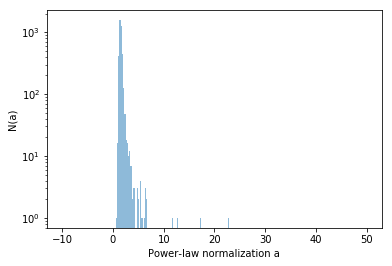

In [172]:
P.hist(aFitExpt[:,0],bins=250,alpha=0.5,range=[-10,50], log=True)
P.xlabel('Power-law normalization a')
P.ylabel('N(a)')

Text(0, 0.5, 'N(b)')

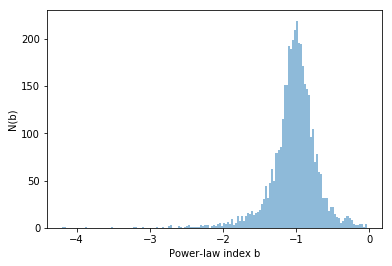

In [173]:
P.hist(aFitExpt[:,1],bins=150,alpha=0.5)
P.xlabel('Power-law index b')
P.ylabel('N(b)')

Text(0, 0.5, 'N(c)')

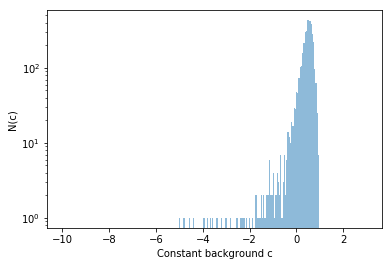

In [174]:
P.hist(aFitExpt[:,2],bins=250,alpha=0.5,log=True, range=[-10,3])
P.xlabel('Constant background c')
P.ylabel('N(c)')

Compared to the two-parameter case, the range of allowed power-law indices is considerable! 

What about the co-variance of the background and the power-law normalization?

(-5, 2)

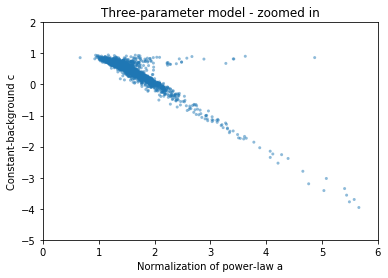

In [175]:
P.scatter(aFitExpt[:,0], aFitExpt[:,2], alpha=0.5, s=9, edgecolor='none')
P.xlabel('Normalization of power-law a')
P.ylabel('Constant-background c')
P.title('Three-parameter model - zoomed in')
P.xlim(0,6)
P.ylim(-5,2)

What can we conclude with behavior like this? At least three things are going on here. Under random time-sampling within the (0.5-5.0) range:

[1]. The fitter we've used here, curve_fit, does not always do a good job fitting given the 3-parameter and the model. Ideally we should be able to fold in other information we might have (e.g. 1/x^3 or steeper might be unphysical). There are (simple!) methods for including these outside constraints, but they're beyond the scope of this HOWTO.

[2]. Even though we have 14 datapoints and 3 model-parameters (so formally 11 degrees of freedom), the range of the data is not sufficient to distinguish the constant background from the power-law normalisation. Our model is too complicated for the data.

[3]. Notice: even with gaussian errors, the distributions of posterior values for the best-fit parameters are not nice well-behaved gaussians! 

### Making progress in sub-optimal situations

Let's try asking a restricted set of simulations as before: assuming the experimenter is able to spread their experiments over time (thus avoiding bunching up of measurements in some cases), what happens then?

In [176]:
aStandard=np.array([])

# suppose we believe the "true" values really are 1.5, -1.0, 0.5
yTrue=f_expt(xMeas,1.5,-1.0,0.5)
for iTrial in range(nTrials):
    
    # Note that the errors are the only source of variation here!
    yTrial = yTrue + np.random.normal(scale=sError,size=np.size(yTrue))
    
    # We use a try/except clause to catch pathologies
    try:
        vTrial, aCova = optimize.curve_fit(f_expt,xMeas,yTrial,vGuess)
    except:
        dumdum=1
        continue  # This moves us to the next loop without stacking.
    
    #here follows the syntax for stacking the trial onto the running sample:
    if np.size(aStandard) < 1:
        aStandard=np.copy(vTrial)
    else:
        aStandard = np.vstack(( aStandard, vTrial ))

In [177]:
np.shape(aStandard)


(3766, 3)

Text(0.5, 1.0, 'Three-parameter model, measurement times frozen')

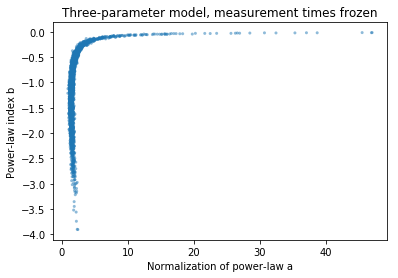

In [178]:
P.scatter(aStandard[:,0], aStandard[:,1], alpha=0.5, s=9, edgecolor='none')
P.xlabel('Normalization of power-law a')
P.ylabel('Power-law index b')
P.title('Three-parameter model, measurement times frozen')

In [179]:
np.shape(aStandard[:,0:2])

(3766, 2)

We'll apply the same incantations in matplotlib to see what this distribution now looks like:

(0.8, 4)

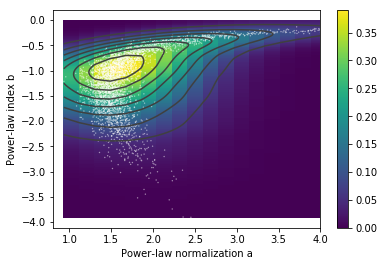

In [180]:
from scipy.stats import kde
xS,yS=aStandard[:,0:2].T
kS = kde.gaussian_kde(aStandard[:,0:2].T)
nbins=250
xiS, yiS = np.mgrid[xS.min():xS.max():nbins*1j, yS.min():yS.max():nbins*1j]
ziS = kS(np.vstack([xiS.flatten(), yiS.flatten()]))

P.pcolormesh(xiS, yiS, ziS.reshape(xiS.shape), zorder=3)
P.colorbar()

# Show the datapoints on top of this, and also the contours. "zorder" sets the vertical order in the plot.
P.scatter(aStandard[:,0], aStandard[:,1], c='w', s=2, zorder=15, edgecolor='none',alpha=0.5)
P.contour(xiS,yiS,ziS.reshape(xiS.shape), zorder=25, colors='0.25')
P.xlabel('Power-law normalization a')
P.ylabel('Power-law index b')

P.xlim(0.8,4)


Again - complex, but more well-behaved. This time the parameter-values and ranges are the following:

In [181]:
print( "Median of best-fit parameters:", np.median(aStandard, axis=0) )

Median of best-fit parameters: [ 1.60161655 -1.03806104  0.51450306]


In [182]:
print("Covariance matrix:")
print( np.cov(np.transpose(aStandard)) )
print( "1-parameter deviations:", np.std(aStandard, axis=0) )


Covariance matrix:
[[ 6.54313464  0.53726724 -6.67738485]
 [ 0.53726724  0.38323566 -0.66401557]
 [-6.67738485 -0.66401557  6.86205094]]
1-parameter deviations: [2.55761553 0.61897811 2.61920386]


Interestingly, the median values returned *when we sample at the times we did* are similar to the truth values we used to simulate the data, but the scatters are difficult to interpret when stated as simple standard deviations!

Text(0.5, 0, 'Power-law normalization a')

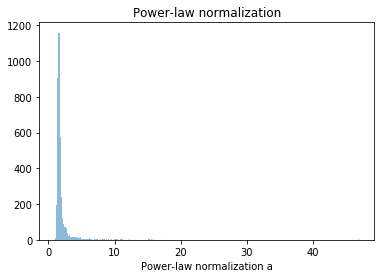

In [183]:
P.hist(aStandard[:,0],bins=250,alpha=0.5)
P.title('Power-law normalization')
P.xlabel('Power-law normalization a')

Text(0.5, 0, 'Power-law index b')

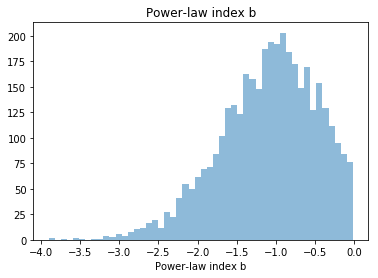

In [184]:
P.hist(aStandard[:,1],bins=50,alpha=0.5)
P.title('Power-law index b')
P.xlabel('Power-law index b')

Text(0.5, 0, 'Background c')

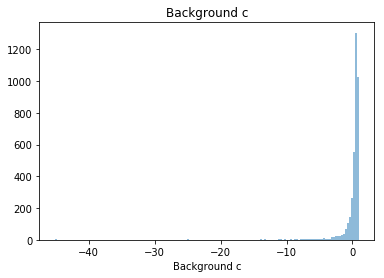

In [185]:
P.hist(aStandard[:,2],bins=150,alpha=0.5)
P.title('Background c')
P.xlabel('Background c')

### Discussion - signal plus unknown background

While the frozen-time example above produces more "well-behaved" results, does it do a better job of representing the parameter-error one would actually encounter? 

Again, that depends on the situation. In some fraction of trials, the uniform random number generator used to make the fake measurement trials, will sometimes produce all 14 measurements at one end of the time interval, in which case the relationship between the "truth" value and the best-fit could change. It might be that your hypothetical experimenter would never let this happen. Or, it might be that this is quite realistic - if, say, you're a ground-based astronomer and weather can very much cause your observations to be bunched up in time (if the only gap in the clouds were near the beginning of the inverse-t decay here).

My view is that it's up to the experimenter to be careful to communicate what they're actually doing, and give the reader as much information as possible to enable them to understand what was actually done, and thus how to interpret the results.

In the general case, it's usually better to err on the side of caution and allow "things to go wrong" in the monte carlo trials. In this case we would conclude that perhaps we got lucky in our experimental data, and any given example of an experiment with ony 14 datapoints from time 0.5-5.0 could return any value within the wider range we found above. What to do?

### Using Monte-Carlo to design better experiments

We can use our simulator to find out what happens if we had just a bit more data, or a long enough time-baseline to actually see the background separate from the power-law - this can be crucial when designing future experiments to really tie down the parameter-values we want. 

In our example, let's suppose we were able to take many more points (35 compared to 14) over a just slightly longer time-baseline (interval 0.5-7 compared to 0.5-5):

<ErrorbarContainer object of 3 artists>

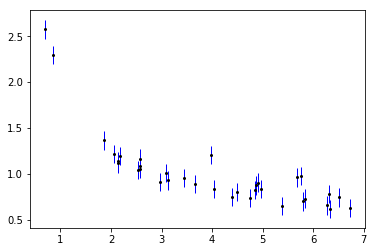

In [186]:
xExtend = np.random.uniform(0.5,7.0,size=35)
yGenera = f_expt(xExtend,1.5,-1.0,0.5)
yMeasur = yGenera + np.random.normal(scale=sError,size=np.size(yGenera))
P.errorbar(xExtend,yMeasur,yerr=sError,lw=0,elinewidth=1,ecolor='b', fmt='ko',markersize=2)


In [187]:
vExten, aExten = optimize.curve_fit(f_expt, xExtend, yMeasur, [2.0,-2.0,0.2])

In [188]:
print(vExten)

[ 1.47477859 -0.99706574  0.50679487]


Let's see how our best-fit parameters compare to the data and to the "truth" parameters:

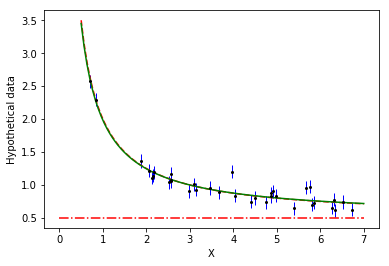

In [189]:
P.errorbar(xExtend,yMeasur,yerr=sError,lw=0,elinewidth=1,ecolor='b', fmt='ko',markersize=2)
P.xlabel('X')
P.ylabel('Hypothetical data')

xFine=np.linspace(0.5,7.0,100)
P.plot(xFine,f_expt(xFine,1.5,-1.0,0.5), 'r--')
P.plot(xFine,f_expt(xFine,*vExten), 'g-')

# Show the "truth" background level for comparison with our planned experimental data
P.plot([0.0,7.0],[0.5,0.5],'r-.')

Now with our better dataset, let's see what happens when we try to recover parameter-ranges on this, without any assumptions on the specific times of the measurements:

In [190]:
aExtend=np.array([])
for iTrial in range(nTrials):
    xTrial = np.random.uniform(0.5,5.0,size=np.size(xExtend))
    yGen = f_expt(xTrial,1.61,-0.97,0.42)
    yTrial = yGen + np.random.normal(scale=sError,size=np.size(yGen))
    
    # We use a try/except clause to catch pathologies
    try:
        vTrial, aCova = optimize.curve_fit(f_expt,xTrial,yTrial,vGuess)
    except:
        dumdum=1
        continue  # This moves us to the next loop without stacking.
    
    #here follows the syntax for stacking the trial onto the running sample:
    if np.size(aExtend) < 1:
        aExtend=np.copy(vTrial)
    else:
        aExtend = np.vstack(( aExtend, vTrial ))

Text(0.5, 1.0, 'Three-parameter model, better data, no assumption on measurement times')

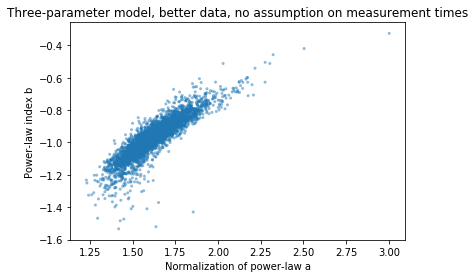

In [191]:
P.scatter(aExtend[:,0],aExtend[:,1], alpha=0.5, s=9, edgecolor='none')
P.xlabel('Normalization of power-law a')
P.ylabel('Power-law index b')
P.title('Three-parameter model, better data, no assumption on measurement times')

Text(0, 0.5, 'Power-law index b')

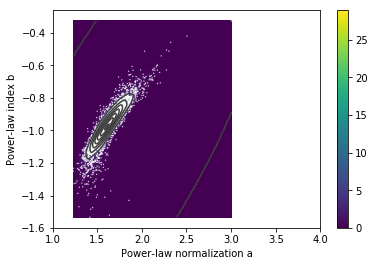

In [192]:
xS,yS=aExtend[:,0:2].T
kS = kde.gaussian_kde(aExtend[:,0:2].T)
nbins=150
xiS, yiS = np.mgrid[xS.min():xS.max():nbins*1j, yS.min():yS.max():nbins*1j]
ziS = kS(np.vstack([xiS.flatten(), yiS.flatten()]))

P.pcolormesh(xiS, yiS, ziS.reshape(xiS.shape), zorder=3)
P.colorbar()

# Show the datapoints on top of this, and also the contours. "zorder" sets the vertical order in the plot.
P.scatter(aExtend[:,0], aExtend[:,1], c='w', s=2, zorder=15, edgecolor='none',alpha=0.75)
P.contour(xiS,yiS,ziS.reshape(xiS.shape), zorder=25, colors='0.25')

P.xlim(1.0,4.0)
#P.ylim(-1.6,-0.45)

P.xlabel('Power-law normalization a')
P.ylabel('Power-law index b')

Text(0, 0.5, 'Constant background c')

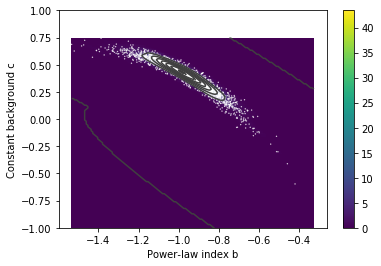

In [193]:
xS,yS=aExtend[:,1:3].T
kS = kde.gaussian_kde(aExtend[:,1:3].T)
nbins=150
xiS, yiS = np.mgrid[xS.min():xS.max():nbins*1j, yS.min():yS.max():nbins*1j]
ziS = kS(np.vstack([xiS.flatten(), yiS.flatten()]))

P.pcolormesh(xiS, yiS, ziS.reshape(xiS.shape), zorder=3)
P.colorbar()

# Show the datapoints on top of this, and also the contours. "zorder" sets the vertical order in the plot.
P.scatter(aExtend[:,1], aExtend[:,2], c='w', s=2, zorder=15, edgecolor='none',alpha=0.75)
P.contour(xiS,yiS,ziS.reshape(xiS.shape), zorder=25, colors='0.25')

#P.xlim(1.21,2.5)
P.ylim(-1.0,1.0)

P.xlabel('Power-law index b')
P.ylabel('Constant background c')

This is already much better-behaved than both previous versions. 

This illustrates another use of monte carlo - to find out how to make our experiment sufficient to set the constraints we want to set.

### Actually reporting the range of returned parameters

Finishing off, let's decide on the range of parameter values to report. Since there are three parameters beyond the experimenter's control, it makes sense to report the range of one at a time, when all three are varying. This is just the projection of our cloud of points onto the parameter-space we want.

(Technique note: quite a lot of the code below is repeated. In practice, you would write a method to do these plots and then just call the method each time you wanted to use it.)

We'll also calculate the two-sided limits from these distributions. We'll start with the 68% limits ("1-sigma") for our hypothetical "Extended" dataset:

INFO: Lower and upper 68 percent ranges are: 0.122 0.146


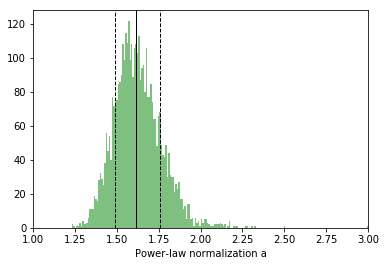

In [194]:
nBins=200
P.hist(aExtend[:,0],bins=nBins,alpha=0.5, color='g')
P.xlim(1,3)
P.xlabel('Power-law normalization a')

# We use the median of the distribution as a decent estimate for 
# our best-fit value. Let's choose a "1-sigma" limit, i.e. the limits
# that enclose 68% of the points between the median and the upper and lower 
# bounds:
Med = np.median(aExtend[:,0])
gHi = np.where(aExtend[:,0] >= np.median(aExtend[:,0]))[0]
gLo = np.where(aExtend[:,0] < np.median(aExtend[:,0]))[0]

# This trick does the limit-setting - try to see how it works:
sLim = 0.68
vSortLo=np.sort(aExtend[gLo,0])
vSortHi=np.sort(aExtend[gHi,0])

NormLo = vSortLo[np.int((1.0-sLim)*np.size(vSortLo))]
NormHi = vSortHi[np.int(sLim      *np.size(vSortHi))]

## Let's take a look - how do those limits look on the histogram?
for quant, ls in zip([Med, NormLo, NormHi],['-', '--', '--']):
    P.axvline(quant, color='k', ls=ls, lw=1)

# Print the limits:
print("INFO: Lower and upper 68 percent ranges are: %.3f %.3f" % (Med-NormLo, NormHi-Med) )


INFO: Lower and upper 68 percent limits are: 0.109 0.109


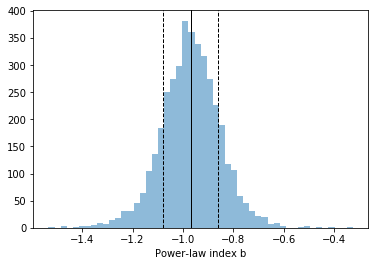

In [195]:
nBins=50
P.hist(aExtend[:,1],bins=nBins,alpha=0.5)
P.xlabel('Power-law index b')

# We use the median of the distribution as a decent estimate for 
# our best-fit value. Let's choose a "1-sigma" limit, i.e. the limits
# that enclose 68% of the points between the median and the upper and lower 
# bounds:
Med = np.median(aExtend[:,1])
gHi = np.where(aExtend[:,1] >= np.median(aExtend[:,1]))[0]
gLo = np.where(aExtend[:,1] < np.median(aExtend[:,1]))[0]

# This trick does the limit-setting - try to see how it works:
vSortLo=np.sort(aExtend[gLo,1])
vSortHi=np.sort(aExtend[gHi,1])

sLim = 0.68
NormLo = vSortLo[np.int((1.0-sLim)*np.size(vSortLo))]
NormHi = vSortHi[np.int(sLim      *np.size(vSortHi))]

## Let's take a look - how do those limits look on the histogram?
for quant, ls in zip([Med, NormLo, NormHi],['-', '--', '--']):
    P.axvline(quant, color='k', ls=ls, lw=1)

# Print the limits:
print("INFO: Lower and upper %i percent limits are: %.3f %.3f" % (sLim*100, Med-NormLo, NormHi-Med) )


Just for interest, let's try a wider limit on the power-law normalization; how asymmetric does the distribution become once we get farther from the median?

INFO: Lower and upper 99 percent ranges are: 0.286 0.510


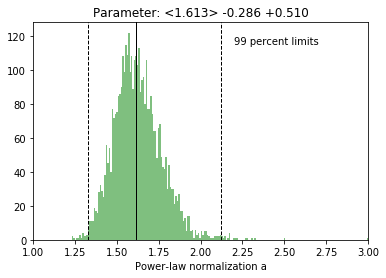

In [196]:
sLim=0.99
nBins=200
P.hist(aExtend[:,0],bins=nBins,alpha=0.5, color='g')
P.xlim(1,3)
P.xlabel('Power-law normalization a')

# Let's find the values at the lower- and upper- "sLim" bounds:
Med = np.median(aExtend[:,0])
gHi = np.where(aExtend[:,0] >= np.median(aExtend[:,0]))[0]
gLo = np.where(aExtend[:,0] < np.median(aExtend[:,0]))[0]

vSortLo=np.sort(aExtend[gLo,0])
vSortHi=np.sort(aExtend[gHi,0])

NormLo = vSortLo[np.int((1.0-sLim)*np.size(vSortLo))]
NormHi = vSortHi[np.int(sLim      *np.size(vSortHi))]

## Let's take a look - how do those limits look on the histogram?
for quant, ls in zip([Med, NormLo, NormHi],['-', '--', '--']):
    P.axvline(quant, color='k', ls=ls, lw=1)


# Do some annotations on the plot with these limits:
P.annotate('%i percent limits' % (sLim*100), (0.6,0.9), xycoords='axes fraction')
P.title('Parameter: <%.3f> -%.3f +%.3f' % (Med, Med-NormLo, NormHi-Med))


#Print the limits:
print("INFO: Lower and upper %i percent ranges are: %.3f %.3f" % (sLim*100,Med-NormLo, NormHi-Med) )


We see the not-so-hidden dangers of reporting and interpreting just a symmetric 1-sigma limit. Even though our measurement errors were gaussian in all cases - and known - the posterior distribution of recovered parameters is (i) not gaussian, (ii) is asymmetric, and (iii) gets more asymmetric the more extreme we make our confidence level (e.g. 99% versus 68%). 

If you have a single 68% range reported (which would be about 0.131), say, how does the likelihood of measuring a=2.2 under this model compare to the actual likelihood of getting this value? Beware of claiming signals only 2 or 3 sigma from the median without first checking the actual distribution of recovered parameters!   

Just for completeness, let's try this on our 14-point data from above, whose monte carlo output we put into aFitExpt earlier. We'll use a log-scale on the histogram to show the long tail of the normalization constant:

INFO: Lower and upper 99 percent ranges are: 0.475 3.141


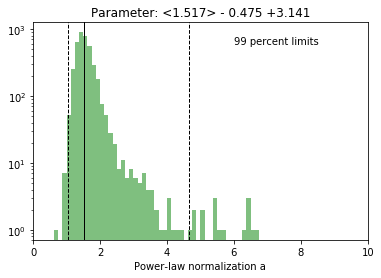

In [197]:
sLim=0.99
nBins=400
P.hist(aFitExpt[:,0],bins=nBins,alpha=0.5, color='g',range=[0,50], log=True)
P.xlim(0,10)
P.xlabel('Power-law normalization a')

# Let's find the values at the lower- and upper- "sLim" bounds:
Med = np.median(aFitExpt[:,0])
gHi = np.where(aFitExpt[:,0] >= Med)[0]
gLo = np.where(aFitExpt[:,0] <  Med)[0]

vSortLo=np.sort(aFitExpt[gLo,0])
vSortHi=np.sort(aFitExpt[gHi,0])

NormLo = vSortLo[np.int((1.0-sLim)*np.size(vSortLo))]
NormHi = vSortHi[np.int(sLim      *np.size(vSortHi))]

## Let's take a look - how do those limits look on the histogram?
P.axvline(Med, color='k', ls='-', lw=1)
P.axvline(NormLo, color='k', ls='--', lw=1)
P.axvline(NormHi, color='k', ls='--', lw=1)

#P.plot([Med, Med],[1,1000.0], 'k-', lw=2)
#P.plot([NormLo, NormLo],[1,1000.0], 'k--', lw=2)
#P.plot([NormHi, NormHi],[1,1000.0], 'k--', lw=2)

# Do some annotations on the plot with these limits:
P.annotate('%i percent limits' % (sLim*100), (0.6,0.9), xycoords='axes fraction')
P.title('Parameter: <%.3f> - %.3f +%.3f' % (Med, Med-NormLo, NormHi-Med))


#Print the limits:
print("INFO: Lower and upper %i percent ranges are: %.3f %.3f" % (sLim*100,Med-NormLo, NormHi-Med) )


Within the context of "designing a better experiment," notice the improvement in the range when using more data over a wider time-baseline over the version with the fewer datapoints just plotted in the above panel; the range of parameters allowed by the data is much narrower when more data over a wider time interval is added. Monte Carlo allows us to quantify the improvement.

Something else is worth noticing here: the coverage of the high-a regime in our simulations is not very good in the long-tail to high positive "a." 

If you want to explore confidence limits in the >90% or so regime, you are likely to need a larger number of simulations just to get good statistics towards the corners of the distribution. Whether you want to do this depends on your use-case and how important the wings of the distribution are likely to be to your hypothetical reader who is trying to reproduce your results.

INFO: Lower and upper 99 percent ranges are: 0.361 0.333


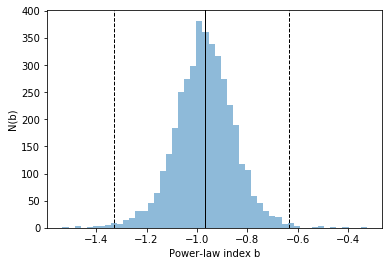

In [198]:
nBins=50
sLim=0.99
P.hist(aExtend[:,1],bins=nBins,alpha=0.5)
P.xlabel('Power-law index b')
P.ylabel('N(b)')

# We use the median of the distribution as a decent estimate for 
# our best-fit value. Let's choose a "1-sigma" limit, i.e. the limits
# that enclose 68% of the points between the median and the upper and lower 
# bounds:
Med = np.median(aExtend[:,1])
gHi = np.where(aExtend[:,1] >= np.median(aExtend[:,1]))[0]
gLo = np.where(aExtend[:,1] < np.median(aExtend[:,1]))[0]

# This trick does the limit-setting - try to see how it works:
vSortLo=np.sort(aExtend[gLo,1])
vSortHi=np.sort(aExtend[gHi,1])

NormLo = vSortLo[np.int((1.0-sLim)*np.size(vSortLo))]
NormHi = vSortHi[np.int(sLim      *np.size(vSortHi))]

## Let's take a look - how do those limits look on the histogram?
for quant, ls in zip([Med, NormLo, NormHi],['-', '--', '--']):
    P.axvline(quant, color='k', ls=ls, lw=1)
#P.plot([Med, Med],[1,500.0], 'k-', lw=2)
#P.plot([NormLo, NormLo],[1,500.0], 'k--', lw=2)
#P.plot([NormHi, NormHi],[1,500.0], 'k--', lw=2)

# Print the limits:
print("INFO: Lower and upper %i percent ranges are: %.3f %.3f" % (sLim*100, Med-NormLo, NormHi-Med)  )
